<a href="https://colab.research.google.com/github/Amarantine-xiv/Another-FF14-Combat-Sim/blob/main/CombatSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 A. Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
VERSION=0.10

In [2]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from dataclasses import dataclass, InitVar, field
import heapq
from enum import Enum

In [3]:
#@title StatFns, JobClassFns

class StatFns:
  @staticmethod
  def get_dh_stat(dh_stat):
    return np.floor(550*(dh_stat-400)/1900)/1000
  
  @staticmethod
  def get_time_using_speed_stat(speed_stat, t):
    return (np.floor((1000*t)*(1000+np.ceil(130*(400-speed_stat)/1900))/10000)/100)

  @staticmethod
  def get_auto_delay(base_weapon_delay, buffs, debuffs):
    return base_weapon_delay*(buffs.haste_time_reduction + debuffs.haste_time_reduction)      

  @staticmethod
  def get_crit_stats(crit_stat):
    crit_rate = (np.floor(200*(crit_stat-400)/1900)+50)/1000
    crit_bonus = (np.floor(200*(crit_stat-400)/1900)+400)/1000
    return crit_rate, crit_bonus

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fAP(main_stat, is_tank= False):
    if is_tank:
      return np.floor(156*(main_stat-390)/390) + 100
    return np.floor(195*(main_stat-390)/390) + 100

  @staticmethod
  def fTnc(tenacity):
    return (1000+np.floor(100*(tenacity-400)/1900))/1000

  @staticmethod
  def fAuto(wd, weapon_delay, job_mod):
    return np.floor(np.floor(390 * job_mod / 1000 + wd) * (weapon_delay / 3))

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fDet(det_stat):
    return np.floor(140*(det_stat-390)/1900) + 1000

  @staticmethod
  # for taking into account bonuses from guranteed dhs.
  def fDetDH(det_stat, dh_stat):
    return np.floor(140*(det_stat-390)/1900) + np.floor(140*(dh_stat-390)/1900) + 1000

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fWD(wd, job_mod):
    return np.floor(390*job_mod/1000 + wd)

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fSpd(speed_stat):
    return np.floor(130 * (speed_stat - 400) / 1900 + 1000)

class JobClassFns:

  # See https://www.akhmorning.com/allagan-studies/modifiers/ . Each class' class num is its main attribute #.
  JOB_MODS = {'SCH': 115, 'SGE': 115, 'WHM': 115, 'WAR': 105, 'SAM': 112, 'RPR': 115, 'DRK': 105, 'PLD': 100, 'GNB': 100, 'TEST': 999}

  @staticmethod
  def compute_trait_dmg_mult(job_class):
    if job_class == 'SCH':
      return 1.30  
    elif job_class == 'SGE':
      return 1.30
    elif job_class == 'WHM':
      return 1.30
    else:
      return 1

  @staticmethod
  def isCaster(job_class):
    return job_class in ['RDM', 'BLM', 'BLU', 'SMN']

  @staticmethod
  def isHealer(job_class):
    return job_class in ['SCH', 'WHM', 'AST', 'SGE']

  @staticmethod
  def isTank(job_class):
    return job_class in ['GNB', 'WAR', 'PLD', 'DRK']


In [4]:
#@title DamageClass, ForcedCritOrDH, Stats, ProcessedStats

# Note: if you rerun this cell after loading the skill library, you will have to re-run the skill library cell because
# Colab will re-initialize the Enums.
class DamageClass(Enum):
    UNKNOWN = 0
    DIRECT = 1
    DOT = 2
    AUTO = 3
    PET = 4

class ForcedCritOrDH(Enum):
  UNKNOWN = 0
  DEFAULT = 1
  FORCE_NO = 2
  FORCE_YES = 3
  FORCE_YES_WITH_NO_DMG_BONUS = 4

@dataclass(frozen=True)
class Stats():
  wd: float
  weapon_delay: float
  main_stat: float
  det_stat: float
  dh_stat: float
  crit_stat: float
  speed_stat: float
  job_class: str  
  tenacity: float = None
  num_roles_in_party: float = 5
  healer_or_caster_strength: float= None
  def __post_init__(self):
     object.__setattr__(self, 'job_mod', JobClassFns.JOB_MODS[self.job_class])
     object.__setattr__(self, 'trait_dmg_mult', JobClassFns.compute_trait_dmg_mult(self.job_class))

@dataclass(frozen=True)
class ProcessedStats():
  stats: InitVar[Stats]

  def __post_init__(self, stats):
    object.__setattr__(self, 'stats', stats)
    (crit_rate, crit_bonus) = StatFns.get_crit_stats(stats.crit_stat)
    object.__setattr__(self, 'crit_rate', crit_rate)
    object.__setattr__(self, 'crit_bonus', crit_bonus)
    object.__setattr__(self, 'det_bonus', StatFns.fDet(stats.det_stat))
    object.__setattr__(self, 'dh_rate', StatFns.get_dh_stat(stats.dh_stat))

  def  __str__(self):
    res = 'Crit rate:' + str(self.crit_rate) + '\n'
    res += 'Crit bonus:' + str(self.crit_bonus) + '\n'
    res += '\nDet bonus:' + str(self.det_bonus) + '\n'
    res += '\nDH Rate:' + str(self.dh_rate)
    res += '\nDot Multiplier:' + str(self.dot_multiplier)    
    return res  

In [5]:
#@title CastSpec, DamageSpec, SkillStatusEffectSpec, Skill

@dataclass(frozen=True)
class CastSpec:
  cast_time: float = 0  
  recast_time: float = 1
  gcd_recast_time: float = None
  is_GCD: bool = True
  animation_lock: float = 0.65
  cast_time_ignores_haste: bool = False
  cast_time_ignores_speed_stat: bool = False
  recast_time_ignores_haste: bool = False
  recast_time_ignores_speed_stat: bool = False
  
  def __post_init__(self):
    if self.gcd_recast_time is None:
      object.__setattr__(self, 'gcd_recast_time', self.recast_time)  


@dataclass(frozen=True)
class DamageSpec:
  potency: float = None
  damage_class: DamageClass = DamageClass.DIRECT
  guaranteed_crit: ForcedCritOrDH = None
  guaranteed_dh: ForcedCritOrDH = None  
  trait_dmg_mult: float = None
  pet_job_mod_override: float = None
  skill_status_effect_denylist: list = None
  # Use to adjust main stat of pet (eg, racial or base stats of pet). This field is ADDED to the player's main stat to get the pet's main stat.
  main_stat_diff_pet: float = 0

  # the fields below are used if the damage is a dot
  dot_duration : float = None
  dot_tick_name : str = ""
  snapshots_buffs: bool = False
  snapshots_debuffs: bool = False

  def  __str__(self):
    res = 'potency:' + str(self.potency) + '\n'
    res += 'guaranteed_crit:' + str(self.guaranteed_crit) + '\n'
    res += 'guaranteed_dh:' + str(self.guaranteed_dh) + '\n'    
    res += 'trait_dmg_mult' + str(self.trait_dmg_mult) + '\n'
    res += 'dot_duration:' + str(self.dot_duration) + '\n'
    res += 'dot_tick_name:' + str(self.dot_tick_name) + '\n'
    res += 'snapshots_buffs:' + str(self.snapshots_buffs)  + '\n'
    res += 'snapshots_debuffs:' + str(self.snapshots_debuffs)  + '\n'
    return res 

@dataclass(frozen=True)
class SkillStatusEffectSpec:
  duration: float
  max_duration: float = None
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  main_stat_add: float= 0
  damage_mult: float= 1
  haste_time_reduction: float= 0
  cast_time_reduction: float= 0

  def __post_init__(self):
    if self.max_duration is None:
      object.__setattr__(self, 'max_duration', self.duration)  

  def  __str__(self):
    res = 'main_stat_add:' + str(self.main_stat_add) + '\n'
    res += 'crit_rate_add:' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add:' + str(self.dh_rate_add) + '\n'
    res += 'damage_mult:' + str(self.damage_mult) + '\n'
    res += 'duration:' + str(self.duration) + '\n'
    res += 'max_duration:' + str(self.max_duration) + '\n'
    res += 'haste_time_reduction:' + str(self.haste_time_reduction)
    return res 

@dataclass(frozen=True)
class Skill:
  name: str
  damage_spec: DamageSpec = None
  buff_spec: SkillStatusEffectSpec = None
  debuff_spec: SkillStatusEffectSpec = None
  cast_spec: CastSpec = None  
  follow_up_skills : tuple = () # a tuple of tuples. Each element in the tuple is of the format (time_delay, skill_name).

  def __gt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name > other.name
  def __lt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name < other.name
  def __eq__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    self.name == other.name

  def __hash__(self):
    return hash(self.name)

  def  __str__(self):
    res = 'name:' + str(self.name) + '\n'
    if self.damage_spec is None:
      res += '---No damage spec---\n'
    else:
      res += str(self.damage_spec)
    if self.buff_spec is None:
      res += '---No skill buff spec---\n'
    else:
      res += str(self.buff_spec)
    if self.follow_up_skills is not None:
      for i in range(0, len(self.follow_up_skills)):
        res += "Follow up skill " + str(i) + ". Delay: " + str(self.follow_up_skills[i][0]) + '\n'
        res += str(self.follow_up_skills[i][0].name) + '\n'
    return res


In [6]:
#@title ComputeDamage
class ComputeDamage:
  @staticmethod
  def _get_guaranteed_crit_dh_bonus_damage(base_damage, guaranteed_crit, guaranteed_dh, buffs, debuffs, crit_bonus):
    # take into account crit rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular crit roll, but we do it here for simplicity.
    res = 0
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES:
      crit_rate_bonus = buffs.crit_rate_add + debuffs.crit_rate_add
      res += np.floor(base_damage*crit_rate_bonus*crit_bonus)

    # take into account dh rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular dh roll, but we do it here for simplicity.
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      dh_rate_bonus = buffs.dh_rate_add + debuffs.dh_rate_add
      res += np.floor(base_damage*dh_rate_bonus*0.25)    
    return res

  @staticmethod
  def compute_pet_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    #skill.damage_spec.skill_buffs_that_dont_apply_to_pets
    
    stats = processed_stats.stats
    is_tank =  JobClassFns.isTank(stats.job_class)
    
    # party bonus to stats does not apply to pets (eg, no 5% bonus for 1 of each type)
    job_mod_use = stats.job_mod if skill.damage_spec.pet_job_mod_override is None else skill.damage_spec.pet_job_mod_override
    job_mod_diff = stats.job_mod - job_mod_use
    main_stat_diff = np.floor(390*job_mod_diff/1000)
    main_stat = (stats.main_stat - main_stat_diff)+ skill.damage_spec.main_stat_diff_pet + buffs.main_stat_add+debuffs.main_stat_add 
    
    potency = skill.damage_spec.potency
    # For whatever reason, pets are never considered tanks, even if they come from a tank. Don't think too hard about it.
    ap = StatFns.fAP(main_stat, is_tank=False)
    wd = StatFns.fWD(stats.wd, job_mod_use)
    det = processed_stats.det_bonus
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = StatFns.fWDfDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity))    
    base_damage = np.floor(base_damage*wd)       

    base_damage += ComputeDamage._get_guaranteed_crit_dh_bonus_damage(base_damage, guaranteed_crit, guaranteed_dh, buffs, debuffs, processed_stats.crit_bonus)
    return base_damage

  @staticmethod
  def compute_direct_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    stats = processed_stats.stats
    is_tank = JobClassFns.isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    # from HINT
    potency = skill.damage_spec.potency
    ap = StatFns.fAP(main_stat, is_tank)
    wd = StatFns.fWD(stats.wd, stats.job_mod)
    det = processed_stats.det_bonus
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    # TODO: move to readme or somewhere better than this.
    # 1) main stat changed by pots/party buffs (# of roles)
    # 2) potency and fAP are taken into account
    # 3) det (and potentially dh if autocrit) is taken into account
    # 4) tnc is taken into account, if applicable (tanks)
    # 5) sps/sks is taken into account, if applicable (eg, dots)
    # 6) weapon damage and weapon delay are taken account, if applicable
    # 7) apply the +1 for dots
    # 8) apply guaranteed crit bonus using crit rate up, if applicable
    # 9) apply guaranteed direct hit bonus dh up, if applicable
    # 10) apply +-5% damage variance (on ALL sources of damage, direct, auto, dot)
    # 11) crit/direct hit multipliers are taken into account, if applicable. NO FLOORING IS DONE HERE (but i can if you think i should)
    # 12) traits are taken into account, if applicable
    # 13) each straight up damage buff/enemy increased damage taken is taken into account multiplicatively. NO FLOORING IS DONE BETWEEN APPLYING BUFFS

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity))    
    base_damage = np.floor(base_damage*wd)       

    base_damage += ComputeDamage._get_guaranteed_crit_dh_bonus_damage(base_damage, guaranteed_crit, guaranteed_dh, buffs, debuffs, processed_stats.crit_bonus)
    return base_damage

  @staticmethod
  def compute_dot_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    # Q: what is the dot damage formula for tanks with tenacity?

    stats = processed_stats.stats
    is_tank = JobClassFns.isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    potency = skill.damage_spec.potency
    spd = StatFns.fSpd(stats.speed_stat)
    ap = StatFns.fAP(main_stat, is_tank)
    det = processed_stats.det_bonus
    wd = StatFns.fWD(stats.wd, stats.job_mod)
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*wd)
    base_damage = base_damage + 1

    base_damage += ComputeDamage._get_guaranteed_crit_dh_bonus_damage(base_damage, guaranteed_crit, guaranteed_dh, buffs, debuffs, processed_stats.crit_bonus)
    return base_damage

  @staticmethod
  def compute_auto_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    stats = processed_stats.stats
    if (JobClassFns.isHealer(stats.job_class) or JobClassFns.isCaster(stats.job_class)):
      # for healers/casters, the statu used to compute autos is strength, not main stat. So use that and pots and party bonus doesn't affect it
      if stats.healer_or_caster_strength is None:
        raise RuntimeError('Cannot compute auto attack damage for healer/caster unless healer_or_caster_strength stat is specified.') 
      auto_main_stat = stats.healer_or_caster_strength      
    else:
      # for non-healers/casters, the stat used to compute autos is our main stat, and we get all the buffs/bonuses on it
      auto_main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
      auto_main_stat = np.floor(auto_main_stat*(1+0.01*stats.num_roles_in_party))
    
    is_tank = JobClassFns.isTank(stats.job_class)
    potency = skill.damage_spec.potency
    spd = StatFns.fSpd(stats.speed_stat)
    ap = StatFns.fAP(auto_main_stat, is_tank)
    det = processed_stats.det_bonus
    weapon_delay = stats.weapon_delay
    auto = StatFns.fAuto(stats.wd, weapon_delay, stats.job_mod)
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = StatFns.fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*auto)

    base_damage += ComputeDamage._get_guaranteed_crit_dh_bonus_damage(base_damage, guaranteed_crit, guaranteed_dh, buffs, debuffs, processed_stats.crit_bonus)

    return base_damage

  @staticmethod
  def get_base_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec is None:
      return None    
    
    if (skill.damage_spec.damage_class == DamageClass.DIRECT):
      base_damage = ComputeDamage.compute_direct_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (skill.damage_spec.damage_class == DamageClass.DOT):
      base_damage = ComputeDamage.compute_dot_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (skill.damage_spec.damage_class == DamageClass.AUTO):
      base_damage = ComputeDamage.compute_auto_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (skill.damage_spec.damage_class == DamageClass.PET):
      base_damage = ComputeDamage.compute_pet_damage(skill, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    else:
      base_damage = None
    return base_damage

In [7]:
#@title All skill specifications

# Convenience objects. These are all immutable so we can use them safely in all skills if we like

class SkillLibrary:
  def __init__(self):
    self._skills = {}
    self._dot_skills = {}
  
  def add_job_class(self, job_class):
    self._skills[job_class] = {}
    self._dot_skills[job_class] = set()
  
  def add_skill(self, job_class, name, damage_spec= None, buff_spec= None, debuff_spec= None, cast_spec= None, follow_up_skills = ()):
    self._skills[job_class][name] = Skill(name,
                                          damage_spec=damage_spec,
                                          buff_spec=buff_spec,
                                          debuff_spec=debuff_spec,
                                          cast_spec=cast_spec,
                                          follow_up_skills=follow_up_skills)

    if damage_spec is not None and damage_spec.dot_duration is not None:
      self._dot_skills[job_class].add(name)

  def get_skill(self, job_class, name):
    return self._skills[job_class][name]

  def is_dot_skill(self, job_class, name):
    return name in self._dot_skills[job_class]

  def is_auto_skill(self, job_class, name):
    return name == 'Auto'

skill_library = SkillLibrary()
skill_library.add_job_class('General')
skill_library.add_skill('General', 'Pot', buff_spec = SkillStatusEffectSpec(duration= 30, main_stat_add=223), cast_spec=CastSpec(cast_time=0, recast_time=270, is_GCD=False, animation_lock=1.3))

SCH_GCD= CastSpec(cast_time=1.5, recast_time=2.5, is_GCD=True, animation_lock= 0.1)
SCH_GCD_INSTANT= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('SCH')
skill_library.add_skill('SCH', 'Auto', damage_spec=DamageSpec(potency=80, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('SCH', 'BroilIV', damage_spec=DamageSpec(potency=295), cast_spec=SCH_GCD)
skill_library.add_skill('SCH', 'RuinII', damage_spec=DamageSpec(potency=220), cast_spec=SCH_GCD_INSTANT)
skill_library.add_skill('SCH', 'EnergyDrain', damage_spec=DamageSpec(potency=100), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('SCH', 'ArtOfWarII', damage_spec=DamageSpec(potency=180), cast_spec=SCH_GCD_INSTANT)
skill_library.add_skill('SCH', 'ChainStrategem', debuff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.10), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('SCH', '_Biolysis_dot', damage_spec=DamageSpec(potency=70, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0.1))
skill_library.add_skill('SCH', 'Biolysis', damage_spec=DamageSpec(damage_class=None, dot_duration=30, dot_tick_name= '_Biolysis_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=SCH_GCD_INSTANT)

SGE_GCD= CastSpec(cast_time=1.5, recast_time=2.5, is_GCD=True, animation_lock=0.1)
SGE_GCD_INSTANT= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('SGE')
skill_library.add_skill('SGE', 'Auto', damage_spec=DamageSpec(potency=80, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('SGE', 'DosisIII', damage_spec=DamageSpec(potency=330), cast_spec=SGE_GCD)
skill_library.add_skill('SGE', 'PhlegmaIII', damage_spec=DamageSpec(potency=600), cast_spec=SGE_GCD_INSTANT)
skill_library.add_skill('SGE', 'ToxikonII', damage_spec=DamageSpec(potency=330), cast_spec=SGE_GCD_INSTANT)
skill_library.add_skill('SGE', 'DykrasiaII', damage_spec=DamageSpec(potency=170), cast_spec=SGE_GCD_INSTANT)
skill_library.add_skill('SGE', 'Pneuma', damage_spec=DamageSpec(potency=330), cast_spec=SGE_GCD)
skill_library.add_skill('SGE', '_EukrasianDosisIII_dot', damage_spec=DamageSpec(potency=70, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('SGE', 'Eukrasia', cast_spec=CastSpec(cast_time=0, recast_time=1.0, is_GCD=True))
skill_library.add_skill('SGE', 'EukrasianDosisIII', damage_spec=DamageSpec(damage_class=None, dot_duration=30, dot_tick_name= '_EukrasianDosisIII_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=CastSpec(cast_time=0, recast_time=2.5, is_GCD=True))

WHM_GCD= CastSpec(cast_time=1.5, recast_time=2.5, is_GCD=True, animation_lock=0.1)
WHM_INSTANT_GCD= CastSpec(cast_time=1.5, recast_time=2.5, is_GCD=True, animation_lock=0.1)
skill_library.add_job_class('WHM')
skill_library.add_skill('WHM', 'Glare', damage_spec=DamageSpec(potency=290), cast_spec=WHM_GCD)
skill_library.add_skill('WHM', '_Dia_dot', damage_spec=DamageSpec(potency=60, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('WHM', 'Dia', damage_spec=DamageSpec(potency=60, dot_duration=30, dot_tick_name= '_Dia_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True))
skill_library.add_skill('WHM', 'PresenceOfMind', buff_spec=SkillStatusEffectSpec(duration=15, haste_time_reduction=0.20), cast_spec= CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('WHM', 'Assize', damage_spec=DamageSpec(potency=400), cast_spec= CastSpec(cast_time=0, recast_time=40, is_GCD=False))
skill_library.add_skill('WHM', 'AfflatusMisery', damage_spec=DamageSpec(potency=1240), cast_spec=WHM_INSTANT_GCD)
skill_library.add_skill('WHM', 'HolyIII', damage_spec=DamageSpec(potency=1240), cast_spec=CastSpec(cast_time=2.5, recast_time=2.5, is_GCD=True))

AST_GCD= CastSpec(cast_time=1.5, recast_time=2.5, is_GCD=True, animation_lock=0.1)
skill_library.add_job_class('AST')
skill_library.add_skill('AST', 'Divination', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.06), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('AST', 'FallMalefic', damage_spec=DamageSpec(potency=250), cast_spec=AST_GCD)
skill_library.add_skill('AST', '_CombustIII_dot', damage_spec=DamageSpec(potency=55, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('AST', 'CombustIII', damage_spec=DamageSpec(dot_duration=30, dot_tick_name= '_CombustIII_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True))
skill_library.add_skill('AST', 'Astrodyne_1', cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('AST', 'Astrodyne_2', buff_spec= SkillStatusEffectSpec(duration=15, haste_time_reduction=0.10), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('AST', 'Astrodyne_3', buff_spec= SkillStatusEffectSpec(duration=15, haste_time_reduction=0.10, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('AST', '_EarthlyStar_Giant_Dominance', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=310), cast_spec= CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('AST', 'EarthlyStar_WithAutoDetonation', cast_spec= CastSpec(cast_time=0, recast_time=60, is_GCD=False), follow_up_skills=((30, '_EarthlyStar_Giant_Dominance')))
skill_library.add_skill('AST', 'Stellar_Detonation', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=310), cast_spec= CastSpec(cast_time=0, recast_time=3, is_GCD=False))
skill_library.add_skill('AST', 'Stellar_Detonation_Small', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=205), cast_spec= CastSpec(cast_time=0, recast_time=3, is_GCD=False))
skill_library.add_skill('AST', 'Lightspeed', buff_spec=SkillStatusEffectSpec(duration=15, cast_time_reduction=2.5), cast_spec= CastSpec(cast_time=0, recast_time=90, is_GCD=False))
skill_library.add_skill('AST', 'GravityII', damage_spec=DamageSpec(potency=130), cast_spec=AST_GCD)
skill_library.add_skill('AST', 'Macrocosmos', damage_spec=DamageSpec(potency=250), cast_spec=CastSpec(cast_time=0, recast_time=180, is_GCD=False, recast_time_ignores_haste=True))
skill_library.add_skill('AST', 'LordOfCrowns', damage_spec=DamageSpec(potency=250), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('AST', 'Card', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.06), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('AST', 'Card_Small', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.03), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))

WAR_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('WAR')
skill_library.add_skill('WAR', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('WAR', 'HeavySwing', damage_spec=DamageSpec(potency=200), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Maim', damage_spec=DamageSpec(potency=300), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'StormsPath', damage_spec=DamageSpec(potency=430), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'StormsEye', damage_spec=DamageSpec(potency=430), buff_spec= SkillStatusEffectSpec(duration=30, max_duration=60, damage_mult=1.10), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Upheaval', damage_spec=DamageSpec(potency=370), cast_spec=CastSpec(cast_time=0, recast_time=30, is_GCD=False))
skill_library.add_skill('WAR', 'Onslaught', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('WAR', 'FellCleave', damage_spec=DamageSpec(potency=490), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'PrimalRend', damage_spec=DamageSpec(potency=700), cast_spec=CastSpec(cast_time=0, recast_time=2.5, is_GCD=True, animation_lock=1.3))
skill_library.add_skill('WAR', 'InnerChaos', damage_spec=DamageSpec(potency=650, guaranteed_crit=ForcedCritOrDH.FORCE_YES,  guaranteed_dh=ForcedCritOrDH.FORCE_YES), cast_spec=CastSpec(cast_time=0, recast_time=2.5, is_GCD=True))
skill_library.add_skill('WAR', 'Tomahawk', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Overpower', damage_spec=DamageSpec(potency=110), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'MythrilTempest', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', 'Orogeny', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(cast_time=0, recast_time=30, is_GCD=False))
skill_library.add_skill('WAR', 'Decimate', damage_spec=DamageSpec(potency=200), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_Maim_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_StormsPath_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_StormsEye_noCombo', damage_spec=DamageSpec(potency=150), cast_spec=WAR_GCD)
skill_library.add_skill('WAR', '_MythrilTempest', damage_spec=DamageSpec(potency=100), cast_spec=WAR_GCD)

PLD_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('PLD')
skill_library.add_skill('PLD', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('PLD', 'FastBlade', damage_spec=DamageSpec(potency=200), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'FightOrFlight', buff_spec=SkillStatusEffectSpec(duration=20, damage_mult=1.25), cast_spec=CastSpec(cast_time=0, recast_time=60,  is_GCD=False))
skill_library.add_skill('PLD', 'RiotBlade', damage_spec=DamageSpec(potency=280), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'RiotBlade_noCombo', damage_spec=DamageSpec(potency=120), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'TotalEclipse', damage_spec=DamageSpec(potency=100), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'ShieldBash', damage_spec=DamageSpec(potency=100), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'ShieldLob', damage_spec=DamageSpec(potency=100), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'Prominence', damage_spec=DamageSpec(potency=170), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'Prominence_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', '_CircleOfScorn_dot', damage_spec=DamageSpec(potency=30, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('PLD', 'CircleOfScorn', damage_spec=DamageSpec(potency=100, dot_duration=15, dot_tick_name='_CircleOfScorn_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=CastSpec(cast_time=0, recast_time=30, gcd_recast_time=2.5, is_GCD=False))
skill_library.add_skill('PLD', 'GoringBlade', damage_spec=DamageSpec(potency=700), cast_spec=CastSpec(cast_time=0, recast_time=60, gcd_recast_time=2.5))
skill_library.add_skill('PLD', 'RoyalAuthority', damage_spec=DamageSpec(potency=380), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'RoyalAuthority_noCombo', damage_spec=DamageSpec(potency=120), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'HolySpirit', damage_spec=DamageSpec(potency=350), cast_spec=CastSpec(cast_time=1.5, recast_time=2.5, animation_lock=0.1))
skill_library.add_skill('PLD', 'HolySpirit_DivineMight', damage_spec=DamageSpec(potency=450), cast_spec=CastSpec(cast_time=0, recast_time=2.5))
skill_library.add_skill('PLD', 'HolySpirit_Requiescat', damage_spec=DamageSpec(potency=650), cast_spec=CastSpec(cast_time=0, recast_time=2.5))
skill_library.add_skill('PLD', 'Requiescat', damage_spec=DamageSpec(potency=300), cast_spec=CastSpec(cast_time=0, recast_time=60, gcd_recast_time=2.5, is_GCD=False))
skill_library.add_skill('PLD', 'HolyCircle', damage_spec=DamageSpec(potency=100), cast_spec=CastSpec(cast_time=1.5, recast_time=2.5, animation_lock=0.1))
skill_library.add_skill('PLD', 'HolyCircle_DivineMight', damage_spec=DamageSpec(potency=200), cast_spec=CastSpec(cast_time=0, recast_time=2.5))
skill_library.add_skill('PLD', 'HolyCircle_Requiescat', damage_spec=DamageSpec(potency=300), cast_spec=CastSpec(cast_time=0, recast_time=2.5))
skill_library.add_skill('PLD', 'Intervene', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(cast_time=0, recast_time=2.5, is_GCD=False))
skill_library.add_skill('PLD', 'Atonement', damage_spec=DamageSpec(potency=380), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'Confiteor', damage_spec=DamageSpec(potency=400), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'Confiteor_Requiescat', damage_spec=DamageSpec(potency=900), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'Explacion', damage_spec=DamageSpec(potency=450), cast_spec=CastSpec(cast_time=0, recast_time=30, gcd_recast_time=2.5, is_GCD=False))
skill_library.add_skill('PLD', 'BladeOfFaith', damage_spec=DamageSpec(potency=200), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'BladeOfFaith_Requiescat', damage_spec=DamageSpec(potency=700), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'BladeOfTruth', damage_spec=DamageSpec(potency=300), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'BladeOfTruth_Requiescat', damage_spec=DamageSpec(potency=800), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'BladeOfValor', damage_spec=DamageSpec(potency=400), cast_spec=PLD_GCD)
skill_library.add_skill('PLD', 'BladeOfValor_Requiescat', damage_spec=DamageSpec(potency=900), cast_spec=PLD_GCD)

GNB_oGCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=False)
GNB_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('GNB')
skill_library.add_skill('GNB', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('GNB', 'KeenEdge', damage_spec=DamageSpec(potency=170), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'NoMercy', buff_spec=SkillStatusEffectSpec(duration=20, damage_mult=1.20), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=False))
skill_library.add_skill('GNB', 'BrutalShell', damage_spec=DamageSpec(potency=270), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'BrutalShell_noCombo', damage_spec=DamageSpec(potency=130), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'DemonSlice', damage_spec=DamageSpec(potency=100), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'LightningShot', damage_spec=DamageSpec(potency=150), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'SolidBarrel', damage_spec=DamageSpec(potency=360), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'SolidBarrel_noCombo', damage_spec=DamageSpec(potency=140), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'BurstStrike', damage_spec=DamageSpec(potency=380), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'DemonSlaughter', damage_spec=DamageSpec(potency=160), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'DemonSlaughter_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', '_SonicBreak_dot', damage_spec=DamageSpec(potency=60, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('GNB', 'SonicBreak', damage_spec=DamageSpec(potency=300, dot_duration=30, dot_tick_name='_SonicBreak_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=True))
skill_library.add_skill('GNB', 'RoughDivide', damage_spec=DamageSpec(potency=150), cast_spec=GNB_oGCD)
skill_library.add_skill('GNB', 'GnashingFang', damage_spec=DamageSpec(potency=380), cast_spec=CastSpec(cast_time=0, recast_time=30))
skill_library.add_skill('GNB', 'SavageClaw', damage_spec=DamageSpec(potency=460), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'WickedTalon', damage_spec=DamageSpec(potency=540), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', '_BowShock_dot', damage_spec=DamageSpec(potency=60, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
skill_library.add_skill('GNB', 'BowShock', damage_spec=DamageSpec(potency=150, dot_duration=15, dot_tick_name='_BowShock_dot', snapshots_buffs = True, snapshots_debuffs = True), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=False))
skill_library.add_skill('GNB', 'JugularRip', damage_spec=DamageSpec(potency=200), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('GNB', 'AbdomenTear', damage_spec=DamageSpec(potency=240), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('GNB', 'EyeGouge', damage_spec=DamageSpec(potency=280), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('GNB', 'FatedCircle', damage_spec=DamageSpec(potency=300), cast_spec=GNB_GCD)
skill_library.add_skill('GNB', 'BlastingZone', damage_spec=DamageSpec(potency=720), cast_spec=CastSpec(cast_time=0, recast_time=30,  is_GCD=False))
skill_library.add_skill('GNB', 'Hypervelocity', damage_spec=DamageSpec(potency=180), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('GNB', 'DoubleDown', damage_spec=DamageSpec(potency=1200), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=True))

DRK_oGCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=False)
DRK_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('DRK')
skill_library.add_skill('DRK', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_dmg_mult=1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('DRK', 'HardSlash', damage_spec=DamageSpec(potency=170), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'SyphonStrike', damage_spec=DamageSpec(potency=260), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'SyphonStrike_noCombo', damage_spec=DamageSpec(potency=120), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Unleash', damage_spec=DamageSpec(potency=120), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Unmend', damage_spec=DamageSpec(potency=150), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Souleater', damage_spec=DamageSpec(potency=340), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Souleater_noCombo', damage_spec=DamageSpec(potency=120), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'FloodOfShadow', damage_spec=DamageSpec(potency=160), buff_spec= SkillStatusEffectSpec(duration=30, max_duration=60, damage_mult=1.10), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('DRK', 'StalwartSoul', damage_spec=DamageSpec(potency=140), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'StalwartSoul_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'EdgeOfShadow', damage_spec=DamageSpec(potency=460), buff_spec= SkillStatusEffectSpec(duration=30, max_duration=60, damage_mult=1.10), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('DRK', '_SaltedEarth_dot', damage_spec=DamageSpec(potency=50, damage_class=DamageClass.DOT), cast_spec=CastSpec(cast_time=0, recast_time=3, is_GCD=False, animation_lock=0))
# This is a ground dot, so it snapshots buffs but NOT debuffs.
skill_library.add_skill('DRK', 'SaltedEarth', damage_spec=DamageSpec(damage_class=None, dot_duration=15, dot_tick_name='_SaltedEarth_dot', snapshots_buffs = True, snapshots_debuffs = False), cast_spec=CastSpec(cast_time=0, recast_time=90, is_GCD=True))
skill_library.add_skill('DRK', 'SaltAndDarkness', damage_spec=DamageSpec(potency=500), cast_spec=CastSpec(cast_time=0, recast_time=20, is_GCD=False))
skill_library.add_skill('DRK', 'Plunge', damage_spec=DamageSpec(potency=150), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('DRK', 'AbyssalDrain', damage_spec=DamageSpec(potency=240), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=False))
skill_library.add_skill('DRK', 'CarveAndSpit', damage_spec=DamageSpec(potency=510), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=False))
skill_library.add_skill('DRK', 'Bloodspiller', damage_spec=DamageSpec(potency=500), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Quietus', damage_spec=DamageSpec(potency=200), cast_spec=DRK_GCD)
skill_library.add_skill('DRK', 'Shadowbringer', damage_spec=DamageSpec(potency=600), cast_spec=CastSpec(cast_time=0, recast_time=60, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_AbyssalDrain', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350,pet_job_mod_override=100, trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_AbyssalPlunge', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350,pet_job_mod_override=100,  trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_Shadowbringer', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=500,pet_job_mod_override=100,  trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_EdgeOfShadow', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350,pet_job_mod_override=100,  trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_Bloodspiller', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350,pet_job_mod_override=100,  trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', '_LivingShadow_CarveAndSpit', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350,pet_job_mod_override=100,  trait_dmg_mult=1, skill_status_effect_denylist=['FloodOfShadow','EdgeOfShadow','DragonSight']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('DRK', 'LivingShadow',follow_up_skills=((6.8+0*2.2, '_LivingShadow_AbyssalDrain'),
                                                                (6.8+1*2.2, '_LivingShadow_AbyssalPlunge'),
                                                                (6.8+2*2.2, '_LivingShadow_Shadowbringer'),
                                                                (6.8+3*2.2, '_LivingShadow_EdgeOfShadow'),
                                                                (6.8+4*2.2, '_LivingShadow_Bloodspiller'),
                                                                (6.8+5*2.2, '_LivingShadow_CarveAndSpit')),
                                              cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('NIN')
skill_library.add_skill('NIN', 'Mug', damage_spec=DamageSpec(potency=150), debuff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('NIN', 'Mug_buffOnly', debuff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('BRD')
skill_library.add_skill('BRD', 'BattleVoice', buff_spec= SkillStatusEffectSpec(duration=15, dh_rate_add=0.2), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('BRD', 'RadiantFinale_coda3', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.06), cast_spec=CastSpec(cast_time=0, recast_time=110, is_GCD=False))
skill_library.add_skill('BRD', 'RadiantFinale_coda2', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.04), cast_spec=CastSpec(cast_time=0, recast_time=110, is_GCD=False))
skill_library.add_skill('BRD', 'RadiantFinale_coda1', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.02), cast_spec=CastSpec(cast_time=0, recast_time=110, is_GCD=False))
skill_library.add_skill('BRD', 'TheWanderersMinuet', damage_spec=DamageSpec(potency=100), buff_spec= SkillStatusEffectSpec(duration=45, crit_rate_add=0.02), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('BRD', 'TheWanderersMinuet_buffOnly', buff_spec= SkillStatusEffectSpec(duration=45, crit_rate_add=0.02), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('SMN')
skill_library.add_skill('SMN', 'SearingLight', buff_spec= SkillStatusEffectSpec(duration=30, damage_mult=1.03), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('MNK')
skill_library.add_skill('MNK', 'Brotherhood', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('DNC')
skill_library.add_skill('DNC', 'Devilment', buff_spec= SkillStatusEffectSpec(duration=20, crit_rate_add=0.2, dh_rate_add=0.2), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))
skill_library.add_skill('DNC', 'TechnicalFinish_buffOnly', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=1.5, is_GCD=True))

skill_library.add_job_class('DRG')
skill_library.add_skill('DRG', 'BattleLitany', buff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.1), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('RPR')
skill_library.add_skill('RPR', 'ArcaneCircle', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.03), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

skill_library.add_job_class('RDM')
skill_library.add_skill('RDM', 'Embolden', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05), cast_spec=CastSpec(cast_time=0, recast_time=120, is_GCD=False))

SAM_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('SAM')
skill_library.add_skill('SAM', '_Fugetsu_Buff', buff_spec= SkillStatusEffectSpec(duration=40, damage_mult=1.13), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('SAM', '_Fuka_Buff', buff_spec=SkillStatusEffectSpec(duration=40, haste_time_reduction=0.13), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('SAM', 'Auto', damage_spec=DamageSpec(potency=90, damage_class=DamageClass.AUTO, trait_dmg_mult= 1), cast_spec=CastSpec(cast_time=0, recast_time=None, is_GCD=False, animation_lock = 0))
skill_library.add_skill('SAM', 'Hakaze', damage_spec=DamageSpec(potency=200), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Shifu', damage_spec=DamageSpec(potency=280), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fuka_Buff'),))
skill_library.add_skill('SAM', 'Jinpu', damage_spec=DamageSpec(potency=280), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fugetsu_Buff'),))
skill_library.add_skill('SAM', 'Enpi', damage_spec=DamageSpec(potency=260), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Fuga', damage_spec=DamageSpec(potency=90), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Gekko', damage_spec=DamageSpec(potency=380), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Magnetsu', damage_spec=DamageSpec(potency=120), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fugetsu_Buff'),))
skill_library.add_skill('SAM', 'Shifu_noCombo', damage_spec=DamageSpec(potency=280), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fugetsu_Buff'),))
skill_library.add_skill('SAM', 'Jinpu_noCombo', damage_spec=DamageSpec(potency=120), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fugetsu_Buff'),))
skill_library.add_skill('SAM', 'Enpi_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Gekko_noCombo', damage_spec=DamageSpec(potency=170), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Gekko_noPositional', damage_spec=DamageSpec(potency=330), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Gekko_noCombo_noPositional', damage_spec=DamageSpec(potency=120), cast_spec=SAM_GCD)
skill_library.add_skill('SAM', 'Magnetsu_noCombo', damage_spec=DamageSpec(potency=100), cast_spec=SAM_GCD, follow_up_skills=((0, '_Fugetsu_Buff'),))

TEST_GCD= CastSpec(cast_time=0, recast_time=2.5, is_GCD=True)
skill_library.add_job_class('TEST')
skill_library.add_skill('TEST', 'Hit1', damage_spec=DamageSpec(potency=170), cast_spec=TEST_GCD)
skill_library.add_skill('TEST', 'Buff1', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=2.0), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('TEST', 'Buff2', buff_spec= SkillStatusEffectSpec(duration=15, damage_mult=3.0), cast_spec=CastSpec(cast_time=0, recast_time=1, is_GCD=False))
skill_library.add_skill('TEST', 'Pet_350', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=350, trait_dmg_mult=1, skill_status_effect_denylist=['Buff1', 'Blah']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))
skill_library.add_skill('TEST', 'Pet_0', damage_spec=DamageSpec(damage_class=DamageClass.PET, potency=0, trait_dmg_mult=1, skill_status_effect_denylist=['Buff1']), cast_spec=CastSpec(cast_time=0, recast_time=0, is_GCD=False))

In [8]:
#@title DpsTracker

class DpsTracker():
  def __init__(self):    
    self.base_damage=np.zeros((5000,1))
    self.crit_rate=np.zeros((5000,1))
    self.crit_bonus=np.zeros((5000,1))
    self.dh_rate = np.zeros((5000,1))
    self.trait_dmg_mult = np.zeros((5000,1))
    self.damage_mult = np.ones((5000,1))
    self.it = 0
    self.isFinalized = False

  def add_damage(self, base_damage, crit_rate, crit_bonus, dh_rate, trait_dmg_mult, damage_mult):
    if not self.isFinalized:
      self.base_damage[self.it] = base_damage
      self.crit_rate[self.it] = crit_rate
      self.crit_bonus[self.it] = crit_bonus
      self.dh_rate[self.it] = dh_rate
      self.trait_dmg_mult[self.it] = trait_dmg_mult
      self.damage_mult[self.it] = damage_mult
      self.it +=1
    else:
      raise RuntimeError('DPS tracker is finalized. Cannot add damage instances.')

  def finalize(self):
    self.base_damage = self.base_damage[0:self.it]
    self.crit_rate = self.crit_rate[0:self.it]
    self.crit_bonus = self.crit_bonus[0:self.it]
    self.dh_rate = self.dh_rate[0:self.it]
    self.trait_dmg_mult = self.trait_dmg_mult[0:self.it]
    self.damage_mult = self.damage_mult[0:self.it]
    self.isFinalized = True

  def compute_damage(self, num_samples):
    num_damage_instances = self.base_damage.shape[0]
    total_damage = np.floor(self.base_damage*(0.95+np.random.rand(num_damage_instances,num_samples)/10))    
    total_damage += np.floor(np.multiply(total_damage, np.multiply(self.crit_bonus, self.crit_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage += np.floor(np.multiply(total_damage, 0.25*(self.dh_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage = np.floor(np.multiply(total_damage, self.trait_dmg_mult))
    total_damage = np.floor(np.multiply(total_damage, self.damage_mult))
    total_damage = np.sum(total_damage,axis=0)
    return total_damage

In [9]:
#@title RotationBuilder

class RotationBuilder():
  def __init__(self, stats, skill_library, fight_start_time=0):    
    self._q = []
    self._stats = stats    
    self._skill_library = skill_library
    self._dot_skills = {}
    self._is_built = False
    self.current_time = fight_start_time
    self.next_gcd_time = fight_start_time
    self._rotation_button_presses = []

    # when building a rotation, we need only track our buffs. Debuffs do not need to be currently tracked due to how the game works.
    self.buffs = StatusEffectsTracker(tracks_buffs=True)

  def get_cast_and_animation_lock_delay(self, skill):  
    cast_time = max(0,skill.cast_spec.cast_time - self.buffs.cast_time_reduction)  
    if not skill.cast_spec.cast_time_ignores_speed_stat:
      cast_time = StatFns.get_time_using_speed_stat(self._stats.speed_stat, cast_time)
    if not skill.cast_spec.cast_time_ignores_haste:
      cast_time = cast_time*(1-self.buffs.haste_time_reduction)
    
    return cast_time + skill.cast_spec.animation_lock

  def get_gcd_time_delay(self, skill):
    
    gcd_recast_time = skill.cast_spec.gcd_recast_time
    if not skill.cast_spec.recast_time_ignores_speed_stat:
      gcd_recast_time = StatFns.get_time_using_speed_stat(self._stats.speed_stat, gcd_recast_time)  
    if not skill.cast_spec.recast_time_ignores_haste:
      gcd_recast_time = gcd_recast_time*(1-self.buffs.haste_time_reduction)
    
    return gcd_recast_time

  def add_next_skill(self, name, job_class_to_use=None, snapshot_buffs=None, snapshot_debuffs=None, guaranteed_crit= None, guaranteed_dh= None):
    if job_class_to_use is None:
        job_class_to_use = self._stats.job_class    
    skill = self._skill_library.get_skill(job_class_to_use, name)

    if skill.cast_spec.is_GCD:
      self.current_time = max(self.current_time, self.next_gcd_time) 

    self.buffs.unapply_all_expired_status_effects(self.current_time)

    if skill.cast_spec.is_GCD:    
      self.next_gcd_time = self.current_time + self.get_gcd_time_delay(skill)    

    self._rotation_button_presses.append((self.current_time, name))

    self.add_skill(self.current_time, name, job_class_to_use=job_class_to_use, snapshot_buffs=snapshot_buffs, snapshot_debuffs=snapshot_debuffs, guaranteed_crit= guaranteed_crit, guaranteed_dh= guaranteed_dh)
    self.current_time += self.get_cast_and_animation_lock_delay(skill)

    self.buffs.apply_status_effects(skill, self.current_time)

  def get_last_event_time(self):
    return max([x[0] for x in self._q])

  @staticmethod
  def _errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec:
      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed crit should only be used for DIRECT damage. If you are seeing this msg, make sure you know what you are doing with guaranteed crit.')

      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_dh is ForcedCritOrDH.FORCE_YES or guaranteed_dh is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed dh should only be used for DIRECT damage. If you are seeing this msg, make sure you know what you are doing with guaranteed dh.')
        
      if skill.damage_spec.guaranteed_crit is not None and guaranteed_crit is not None:
        raise RuntimeError('Cannot specify guaranteed crit in skill spec and on this particular damage instance. Only one or the other should be specified.')
      if skill.damage_spec.guaranteed_dh is not None and guaranteed_dh is not None:
        raise RuntimeError('Cannot specify guaranteed dh in skill spec and on this particular damage instance. Only one or the other should be specified.')

  @staticmethod
  def _get_guaranteed_crit_dh(skill, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec:
      if skill.damage_spec.guaranteed_crit is not None:
        guaranteed_crit = skill.damage_spec.guaranteed_crit
      if skill.damage_spec.guaranteed_dh is not None:
        guaranteed_dh = skill.damage_spec.guaranteed_dh
      
    # neither the innate skill nor the adding of the skill specifies crit/dh. Default to the default behaviour.
    if guaranteed_crit is None:
      guaranteed_crit = ForcedCritOrDH.DEFAULT
    if guaranteed_dh is None:
      guaranteed_dh = ForcedCritOrDH.DEFAULT
    return guaranteed_crit, guaranteed_dh

  @staticmethod
  def _get_damage_snapshot_time(skill, t, buffs=None):
    # TODO: this is bugged- we need to consider cast speed buffs before calculating damage snapshot time (or we need to refactor how this works)
    cast_time_reduction = buffs.cast_time_reduction if buffs is not None else 0
    cast_time = skill.cast_spec.cast_time - cast_time_reduction
    return t + max(cast_time - 0.5, 0)

  def add_skill(self, t, name, job_class_to_use=None, snapshot_buffs=None, snapshot_debuffs=None, guaranteed_crit= None, guaranteed_dh= None):
    if job_class_to_use is None:
      job_class_to_use = self._stats.job_class

    skill = self._skill_library.get_skill(job_class_to_use, name)      
    RotationBuilder._errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh)
    guaranteed_crit, guaranteed_dh = RotationBuilder._get_guaranteed_crit_dh(skill, guaranteed_crit, guaranteed_dh)
    damage_snapshot_time = RotationBuilder._get_damage_snapshot_time(skill, t)  

    if self._skill_library.is_dot_skill(job_class_to_use, name):
      if(self._is_built):
        raise RuntimeError("Cannot add a dot skill after rotation is built. It will not be expanded to all dot ticks correctly.")

      if skill not in self._dot_skills:
        self._dot_skills[skill] = []
      # Dot ticks themselves never snapshot buffs/debuffs   
      self._dot_skills[skill].append((damage_snapshot_time, guaranteed_crit, guaranteed_dh))

    else:
      heapq.heappush(self._q, (damage_snapshot_time, skill, snapshot_buffs, snapshot_debuffs, guaranteed_crit, guaranteed_dh, skill.follow_up_skills))      

  def get_next_event(self):
    return heapq.heappop(self._q)

  def is_empty(self):    
    return len(self._q) == 0

  def _process_dot_skills(self, end_time= None):
    if end_time is None:
      end_time = np.Inf

    for skill in self._dot_skills:
      # add tombstone ending skill to signify the end of the fight.
      self._dot_skills[skill].append((end_time, None, None))
      self._dot_skills[skill].sort(key=lambda x: x[0])
      for i in range(0, len(self._dot_skills[skill])-1):
        # Note: guaranteed_crit, guaranteed_dh refer to the damage portion ON the application of the dot, not the dot part itself.
        dot_time, guaranteed_crit, guaranteed_dh = self._dot_skills[skill][i]
        next_dot_time = self._dot_skills[skill][i+1][0]
        curr_dot_duration = int(min(next_dot_time - dot_time, skill.damage_spec.dot_duration))
        
        follow_up_skills=tuple((delay, skill.damage_spec.dot_tick_name) for delay in range(0, curr_dot_duration,3))
        heapq.heappush(self._q, (dot_time, skill, None, None, guaranteed_crit, guaranteed_dh, follow_up_skills))

  def print_sequential_rotation(self):
    for (skill_name, time) in self._rotation_button_presses:
      print('Time: {time}, Skill name: {skill_name}'.format(time=time, skill_name=skill_name))

  def print_damage_snapshots(self):
    for i in self._q:
      print('Time: {time}, Skill name: {skill_name}'.format(time=i[0], skill_name=i[1].name))

  def _add_autos(self, end_time):
    buffs = StatusEffectsTracker(tracks_buffs=True)
    auto_attack_time = self._stats.weapon_delay
    rot_use = copy.deepcopy(self)
    all_hastes = []
    while not rot_use.is_empty():
      (t, skill, _, _, _, _, _) = rot_use.get_next_event()    
      buffs.unapply_all_expired_status_effects(t)
      buffs.apply_status_effects(skill, t)
      all_hastes.append((t,buffs.haste_time_reduction))
    
    # If no end time is specified, just take the last cast event as the final
    # action.
    if end_time is None:
      end_time = max([x[0] for x in rb._q])
    
    curr_auto_time = 0
    while curr_auto_time < end_time:
      self.add_skill(curr_auto_time, 'Auto')
      ind = next((i for i in range(0, len(all_hastes)) if all_hastes[i][0] >= curr_auto_time), None)
      haste_buff_use = 0 if ind is None else all_hastes[ind][1]
      auto_delay_time = np.floor(100*self._stats.weapon_delay*(1-haste_buff_use))/100
      curr_auto_time = auto_delay_time+curr_auto_time    
      
  def build(self, enable_autos=False, end_time= None):
    res = copy.deepcopy(self)
    if enable_autos:
      res._add_autos(end_time)
    res._process_dot_skills(end_time)    
    res._is_built = True
    res._q.sort()
    return res

In [10]:
#@title StatusEffectsTracker

class StatusEffectsTracker:
  def __init__(self, tracks_buffs, status_effects= None):
    self.tracks_buffs = tracks_buffs
    self.active = {}
    self.damage_mult = 1
    self.crit_rate_add = 0
    self.dh_rate_add = 0
    self.main_stat_add = 0
    self.haste_time_reduction = 0 
    self.cast_time_reduction = 0
            
  def _do_apply_status_effect(self, skill, status_effect_spec, t):
    if skill not in self.active.keys():
      self.active[skill] = t
      self.apply_augment(status_effect_spec)
      
    self.active[skill] = min(self.active[skill] + status_effect_spec.duration,
                            t + status_effect_spec.max_duration)

  def  __str__(self):
    res = 'tracks_buffs:' + str(self.tracks_buffs) + '\n'
    res += 'active effects: \n'
    res += 'damage_mult: ' + str(self.damage_mult) + '\n'
    res += 'crit_rate_add: ' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add: ' + str(self.dh_rate_add) + '\n'
    res += 'main_stat_add: ' + str(self.main_stat_add) + '\n'
    res += 'haste_time_reduction: ' + str(self.haste_time_reduction) + '\n'
    res += 'cast_time_reduction: ' + str(self.cast_time_reduction) + '\n'
    for key in self.active.keys():
      res += '   ' + str(key.name) + '\n'
    return res 

  def apply_augment(self, other):
    self.main_stat_add += other.main_stat_add
    self.crit_rate_add += other.crit_rate_add
    self.dh_rate_add += other.dh_rate_add
    self.haste_time_reduction += other.haste_time_reduction
    self.damage_mult *= other.damage_mult
    self.cast_time_reduction += other.cast_time_reduction
  
  def unapply_augment(self, other):
    self.main_stat_add -= other.main_stat_add
    self.crit_rate_add -= other.crit_rate_add
    self.dh_rate_add -= other.dh_rate_add
    self.haste_time_reduction -= other.haste_time_reduction
    self.damage_mult /= other.damage_mult
    self.cast_time_reduction -= other.cast_time_reduction

  def apply_status_effects(self, skill, t):
    if self.tracks_buffs:
      if skill.buff_spec is not None:
          self._do_apply_status_effect(skill, skill.buff_spec, t)
    else:
      if skill.debuff_spec is not None:
          self._do_apply_status_effect(skill, skill.debuff_spec, t)

  def _do_unapply_status_effect(self, skill, status_effect_spec):
      if skill not in self.active.keys():
        raise RuntimeError('Error: attempting to unapply a status effect that is not currently active.')

      self.unapply_augment(status_effect_spec)
      del self.active[skill]

  def unapply_all_expired_status_effects(self, t):
    active_skills = list(self.active.keys())
    for skill in active_skills:
      is_expired = self.active[skill] < t
      if is_expired:
        if self.tracks_buffs and skill.buff_spec is not None:
          self._do_unapply_status_effect(skill, skill.buff_spec)
        if (not self.tracks_buffs) and skill.debuff_spec is not None:
          self._do_unapply_status_effect(skill, skill.debuff_spec)

In [11]:
#@title Simulator
class Simulator:
  def __init__(self, stats, rotation, num_samples = 1000000, verbose=False):
    self.stats = stats
    self.rotation = rotation
    self.num_samples = num_samples    
    self.buffs = StatusEffectsTracker(tracks_buffs=True)
    self.debuffs = StatusEffectsTracker(tracks_buffs=False)
    self.verbose = verbose

  def _compute_crit_rates_and_bonuses(processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      crit_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      crit_rate = 0
    else:
      crit_rate = processed_stats.crit_rate + buffs.crit_rate_add + debuffs.crit_rate_add
    crit_bonus = processed_stats.crit_bonus

    if guaranteed_dh is ForcedCritOrDH.FORCE_YES or guaranteed_dh is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      dh_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      dh_rate = 0
    else:
      dh_rate = processed_stats.dh_rate + buffs.dh_rate_add + debuffs.dh_rate_add
    return (crit_rate, crit_bonus, dh_rate)
  
  def _update_rotation(self, snapshot_buffs, snapshot_debuffs, follow_up_skills, t):
    if follow_up_skills is not None:      
      for i in range (0, len(follow_up_skills)):
        delay, follow_up_skill_name = follow_up_skills[i]        
        self.rotation.add_skill(t+delay,follow_up_skill_name, snapshot_buffs=snapshot_buffs, snapshot_debuffs=snapshot_debuffs)

  def _unapply_all_expired_status_effects(self, time):
    self.buffs.unapply_all_expired_status_effects(time)
    self.debuffs.unapply_all_expired_status_effects(time)

  def _apply_status_effects(self, skill, time):
    self.buffs.apply_status_effects(skill, time)
    self.debuffs.apply_status_effects(skill, time)

  @staticmethod
  def _unapply_status_effects_in_denylist(skill, buffs, debuffs):
    if skill.damage_spec is None or skill.damage_spec.skill_status_effect_denylist is None:
      return
    
    for active_buff_skill in buffs.active:
      if active_buff_skill.name in skill.damage_spec.skill_status_effect_denylist:
        buffs.unapply_augment(active_buff_skill.buff_spec)
        
    for active_debuff_skill in debuffs.active:
      if active_debuff_skill.name in skill.damage_spec.skill_status_effect_denylist:
        debuffs.unapply_augment(active_buff_skill.debuff_spec)    

  def simulate(self):
    processed_stats = ProcessedStats(self.stats)
    dps_tracker = DpsTracker()    
    
    while not self.rotation.is_empty():
      (time, skill, snapshot_buffs, snapshot_debuffs, guaranteed_crit, guaranteed_dh, follow_up_skills) = self.rotation.get_next_event()
      self._unapply_all_expired_status_effects(time)      

      # make defensive copies of buffs- we may need to modify them
      buffs_to_use = copy.deepcopy(self.buffs) if snapshot_buffs is None else snapshot_buffs
      debuffs_to_use = copy.deepcopy(self.debuffs) if snapshot_debuffs is None else snapshot_debuffs
      Simulator._unapply_status_effects_in_denylist(skill, buffs_to_use, debuffs_to_use)

      if self.verbose:
        print('Time: {time}, Skill name: {skill_name}'.format(time=time, skill_name=skill.name))
        print("Buffs: ")
        print(buffs_to_use)
        print("Debuffs: ")
        print(debuffs_to_use)
          
      base_damage = ComputeDamage.get_base_damage(skill, processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)
      if base_damage is not None:
        (crit_rate, crit_bonus, dh_rate) = Simulator._compute_crit_rates_and_bonuses(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)
 
        trait_dmg_mult = stats.trait_dmg_mult if skill.damage_spec.trait_dmg_mult is None else skill.damage_spec.trait_dmg_mult        
        dmg_mult = buffs_to_use.damage_mult*debuffs_to_use.damage_mult        
        dps_tracker.add_damage(base_damage, crit_rate, crit_bonus, dh_rate, trait_dmg_mult, dmg_mult)      
            
      self._apply_status_effects(skill, time)
      
      snapshot_buffs = copy.deepcopy(self.buffs) if (skill.damage_spec and skill.damage_spec.snapshots_buffs) else None
      snapshot_debuffs = copy.copy(self.debuffs) if (skill.damage_spec and skill.damage_spec.snapshots_debuffs) else None
      self._update_rotation(snapshot_buffs, snapshot_debuffs, follow_up_skills, time)    

    dps_tracker.finalize()
    total_damage = dps_tracker.compute_damage(self.num_samples)
    return total_damage, dps_tracker

In [12]:
#@title Display results
def display_results(total_damage, fight_time, verbose=True):
  PERCENTILES_TO_USE = [25,50,75,95,99]
  COLOURS_TO_USE = ['g', 'b', (0.36, 0.28, 0.55), (1,0.5,0), (0.68,0.14,0.37)]
  percs = np.percentile(total_damage, PERCENTILES_TO_USE)
  count, bins_count = np.histogram(total_damage, bins=1000)
  pdf = count / sum(count)
  cdf = np.cumsum(pdf)
  plt.figure()
  plt.plot(bins_count[1:], pdf, label="PDF")
  for i in range(len(percs)):
    plt.plot([percs[i], percs[i]], [0, max(pdf)], color=COLOURS_TO_USE[i])
  plt.figure()
  plt.plot(bins_count[1:], cdf, label="CDF")
  plt.title('CDF of rotation')
  plt.xlabel('Total damage')
  plt.ylabel('Cumulative probability')
  if(verbose):
    print('Average damage: ' + str(np.mean(total_damage)))
    print('Average dps: ' + str(np.mean(total_damage/fight_time)))
    for i in range(0, len(PERCENTILES_TO_USE)):
      print('dps percentile ' + str(PERCENTILES_TO_USE[i]) + ': ' + str(percs[i]/fight_time))

In [13]:
#@title Test utils

class AllTestResults:
  def __init__(self):
    self.passing = []
    self.failing = []

  def _add_pass(self, test_name):
    self.passing.append(test_name)

  def _add_failure(self, test_name):
    self.failing.append(test_name)

  def update_test_results(self, test_passed, test_name):
    if test_passed:
      self._add_pass(test_name)
    else:
      self._add_failure(test_name)
  
  def print_result(self):
    print('{passing}/{total} tests passed.'.format(passing=len(self.passing), total=len(self.passing)+len(self.failing)))
    if len(self.failing) > 0:
      print('Failing tests: ')
      for test_name in self.failing:
        print(test_name)

def do_test(test_name, sim, expected_dps, fight_time, tol=0.02, verbose=False):
  print('===Doing test: {test_name}==='.format(test_name=test_name))  

  start_time = time.time()
  total_damage, dps_tracker = sim.simulate()
  end_time = time.time()
  
  print('Time taken: ' + str(end_time-start_time))

  actual_dps = np.mean(total_damage)/fight_time
  print("expected vs actual dps: {expected}, {actual}".format(expected=expected_dps, actual=actual_dps))
  
  test_passed = np.abs((expected_dps - actual_dps)/expected_dps) < tol
  test_result = "PASS" if test_passed else "FAIL"
  print("Test result: {result}".format(result=test_result))

  if verbose:
    display_results(total_damage, fight_time, verbose)

  return total_damage, dps_tracker, test_passed


In [14]:
TEST_KEYS= ['all']
all_test_results = AllTestResults()

===Doing test: WHM with POM===
Time taken: 0.290771484375
expected vs actual dps: 7298, 7293.375726912221
Test result: PASS
Average damage: 217021.68813
Average dps: 7293.375726912222
dps percentile 25: 6997.345073262537
dps percentile 50: 7271.558677241566
dps percentile 75: 7564.72644172604
dps percentile 95: 8016.166487431108
dps percentile 99: 8345.612649549672


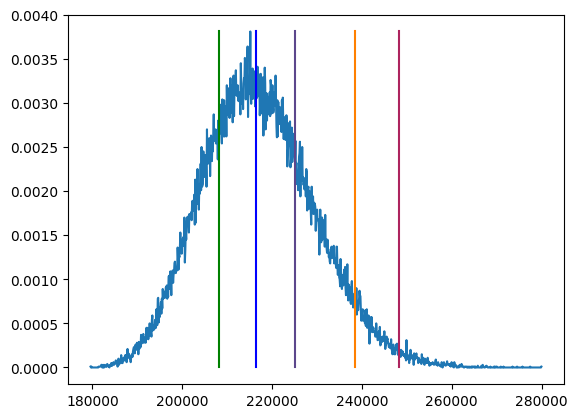

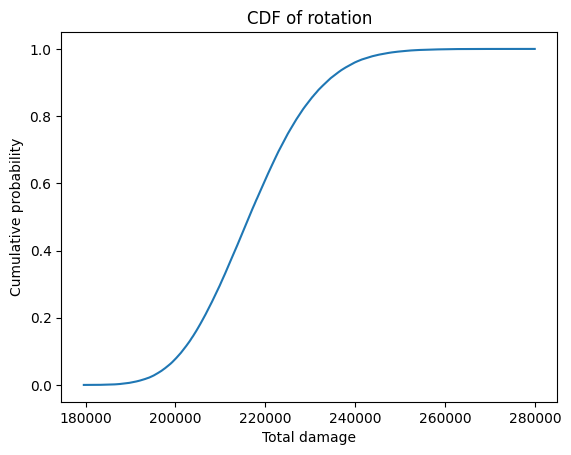

In [15]:
#@title WHM with POM
test_name = 'WHM with POM'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'WHM')
  rb = RotationBuilder(stats, skill_library, fight_start_time=-1.5)

  rb.add_next_skill('Glare')
  rb.add_next_skill('Dia')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('PresenceOfMind')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Assize')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')
  rb.add_next_skill('Glare')

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 7298, rb.get_last_event_time(), verbose=True)
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: WAR 2.46 bis, opener===
Time taken: 0.31155943870544434
expected vs actual dps: 11565, 11565.415332395245
Test result: PASS
Average damage: 369861.98233
Average dps: 11565.415332395247
dps percentile 25: 11322.73295809881
dps percentile 50: 11551.75109443402
dps percentile 75: 11793.378674171354
dps percentile 95: 12146.280487804876
dps percentile 99: 12392.527204502812


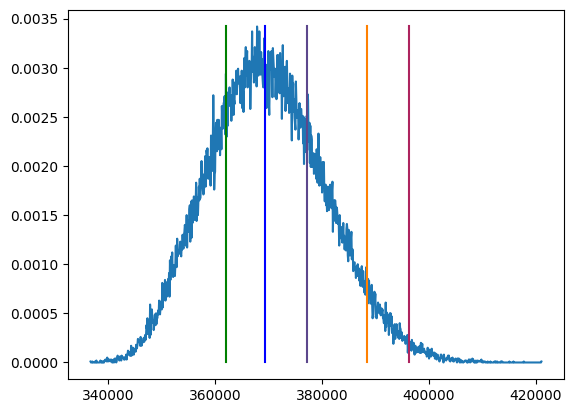

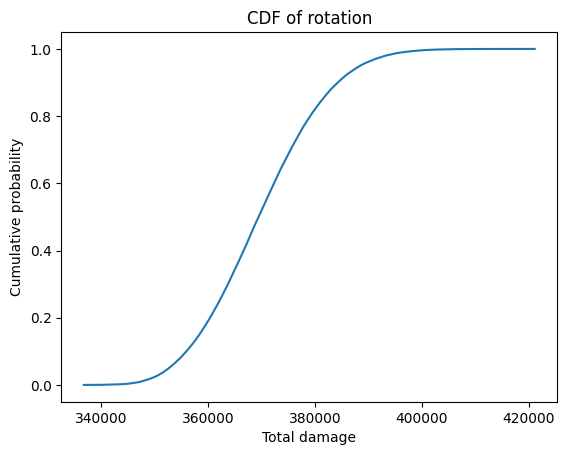

In [16]:
#@title WAR 2.46 6.3 bis, opener
test_name = 'WAR 2.46 bis, opener'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'WAR')
  rb= RotationBuilder(stats, skill_library)

  # Should return ~11558 average dps
  rb.add_skill(6.3, 'ChainStrategem', 'SCH')
  rb.add_skill(7.1, 'BattleLitany', 'DRG')
  rb.add_skill(0.8, 'ArcaneCircle', 'RPR')
  rb.add_skill(6.28, 'Embolden', 'RDM')

  rb.add_next_skill('HeavySwing')
  rb.add_next_skill('Maim')
  rb.add_next_skill('Pot', 'General')
  rb.add_next_skill('StormsEye')
  rb.add_next_skill('InnerChaos')
  rb.add_next_skill('Upheaval')
  rb.add_next_skill('Onslaught')
  rb.add_next_skill('PrimalRend')
  rb.add_next_skill('InnerChaos')
  rb.add_next_skill('Onslaught')
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('Onslaught')
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('HeavySwing')
  rb.add_next_skill('Maim')
  rb.add_next_skill('StormsPath')
  rb.add_next_skill('FellCleave')
  rb.add_next_skill('InnerChaos')

  sim = Simulator(stats, rb.build(enable_autos=True), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 11565, rb.get_last_event_time(), verbose=True)
  all_test_results.update_test_results(test_passed, test_name)


In [17]:
#@title DRK

test_name = 'DRK'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  # uses bis set: https://etro.gg/gearset/8456e35b-2ae2-411a-b9cb-62ebe7f8b1f0
  stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'DRK')
  gcd_time = StatFns.get_time_using_speed_stat(stats.speed_stat, 2.5)
  rb= RotationBuilder(stats, skill_library)

  #log: https://www.fflogs.com/reports/PXKa14VZBHRQdM3x/
  rb.add_skill(6.62, 'Pot', 'General')

  rb.add_skill(0.58, 'Unmend')
  rb.add_skill(3.11, 'HardSlash')  
  rb.add_skill(3.77, 'EdgeOfShadow')
  rb.add_skill(5.55, 'SyphonStrike')
  rb.add_skill(7.99, 'Souleater')
  rb.add_skill(8.61, 'LivingShadow')
  rb.add_skill(9.28, 'SaltedEarth')
  rb.add_skill(10.44, 'Bloodspiller')
  rb.add_skill(11.06, 'Shadowbringer')
  rb.add_skill(11.73, 'EdgeOfShadow')
  rb.add_skill(12.88, 'Bloodspiller')
  rb.add_skill(13.54, 'CarveAndSpit')
  rb.add_skill(14.21, 'Plunge')
  rb.add_skill(15.32, 'Bloodspiller')
  rb.add_skill(15.99, 'EdgeOfShadow')
  rb.add_skill(16.62, 'SaltAndDarkness')
  rb.add_skill(17.77, 'HardSlash')
  rb.add_skill(18.44, 'Plunge')  
  rb.add_skill(19.10, 'EdgeOfShadow')  
  rb.add_skill(20.26, 'SyphonStrike')
  rb.add_skill(21.10, 'Shadowbringer')
  rb.add_skill(21.72, 'EdgeOfShadow')
  rb.add_skill(22.70, 'Souleater')
  rb.add_skill(25.12, 'HardSlash')
  rb.add_skill(27.63, 'SyphonStrike')
  rb.add_skill(30.12, 'Souleater')

#  # Manually input autos to match the log exactly.
  rb.add_skill(3.15, 'Auto')
  rb.add_skill(6.13, 'Auto')
  rb.add_skill(9.10, 'Auto')
  rb.add_skill(12.08, 'Auto')
  rb.add_skill(15.06, 'Auto')
  rb.add_skill(18.04, 'Auto')
  rb.add_skill(21.01, 'Auto')
  rb.add_skill(23.99, 'Auto')
  rb.add_skill(26.96, 'Auto')
  rb.add_skill(29.94, 'Auto')

  fight_time=30.12

  sim = Simulator(stats, rb.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 12229, fight_time, verbose=False)
  all_test_results.update_test_results(test_passed, test_name)
  


===Doing test: DRK===
Time taken: 0.7841968536376953
expected vs actual dps: 12229, 12228.83362184595
Test result: PASS


In [18]:
#@title GNB

test_name = 'GNB'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  
  # uses 2.5 gcd gearset: https://etro.gg/gearset/3c586380-f796-4502-9621-c9d00816cb81
  stats = Stats(wd=126, weapon_delay=2.80, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'GNB')
  gcd_time = StatFns.get_time_using_speed_stat(stats.speed_stat, 2.5)
  rb= RotationBuilder(stats, skill_library)

  # Doesn't matter what order we add these since none are haste buffs.
  rb.add_skill(4.68, 'Mug_buffOnly', 'NIN')
  rb.add_skill(1.25, 'TheWanderersMinuet_buffOnly', 'BRD')
  rb.add_skill(6.10, 'BattleVoice', 'BRD')
  rb.add_skill(6.82, 'RadiantFinale_coda1', 'BRD')
  rb.add_skill(7.17, 'Brotherhood', 'MNK')
  rb.add_skill(2.54, 'SearingLight', 'SMN')
  rb.add_skill(7.04, 'ChainStrategem', 'SCH')

  # Actually skills/button presses from GNB
  rb.add_skill(-0.8, 'LightningShot')
  rb.add_skill(0.179, 'KeenEdge')
  rb.add_skill(2.72, 'BrutalShell')
  rb.add_skill(3.38, 'NoMercy')
  rb.add_skill(5.21, 'GnashingFang')
  rb.add_skill(5.97, 'JugularRip')
  rb.add_skill(7.75, 'SonicBreak')
  rb.add_skill(8.37, 'BlastingZone')
  rb.add_skill(9.04, 'BowShock')
  rb.add_skill(10.29, 'DoubleDown')
  rb.add_skill(10.87, 'RoughDivide')
  rb.add_skill(12.83, 'SavageClaw')
  rb.add_skill(13.27, 'AbdomenTear')
  rb.add_skill(13.94, 'RoughDivide')
  rb.add_skill(15.33, 'WickedTalon')
  rb.add_skill(16.04, 'EyeGouge')
  rb.add_skill(17.83, 'SolidBarrel')
  rb.add_skill(20.32, 'BurstStrike')
  rb.add_skill(20.89, 'Hypervelocity')
  rb.add_skill(22.81, 'KeenEdge')

  # Manually input autos to recreate log
  rb.add_skill(0.71, 'Auto')
  rb.add_skill(3.52, 'Auto')
  rb.add_skill(6.33, 'Auto')
  rb.add_skill(9.13, 'Auto')
  rb.add_skill(11.94, 'Auto')
  rb.add_skill(14.75, 'Auto')
  rb.add_skill(17.55, 'Auto')
  rb.add_skill(20.36, 'Auto')

  fight_time=22.81

  # Manually inputted autos, so no need to set enable_autos=True (that would be a bug since it would double the autos done).
  sim = Simulator(stats, rb.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 12677, fight_time, verbose=False)
  all_test_results.update_test_results(test_passed, test_name)


===Doing test: GNB===
Time taken: 0.6642701625823975
expected vs actual dps: 12677, 12678.598653222272
Test result: PASS


===Doing test: PLD===
Time taken: 0.5665395259857178
expected vs actual dps: 9948, 9944.473532666667
Test result: PASS
Average damage: 298334.20598
Average dps: 9944.473532666663
dps percentile 25: 9501.725
dps percentile 50: 9904.433333333332
dps percentile 75: 10343.141666666666
dps percentile 95: 11015.501666666667
dps percentile 99: 11511.1


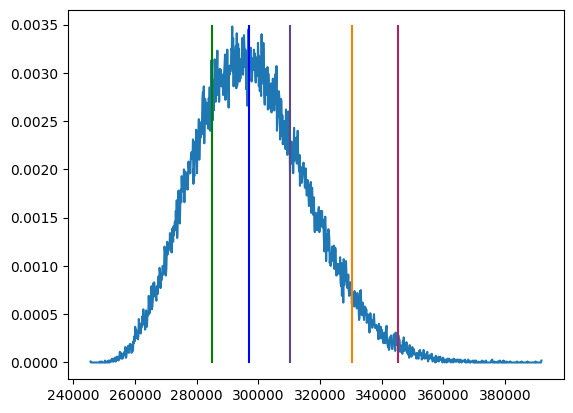

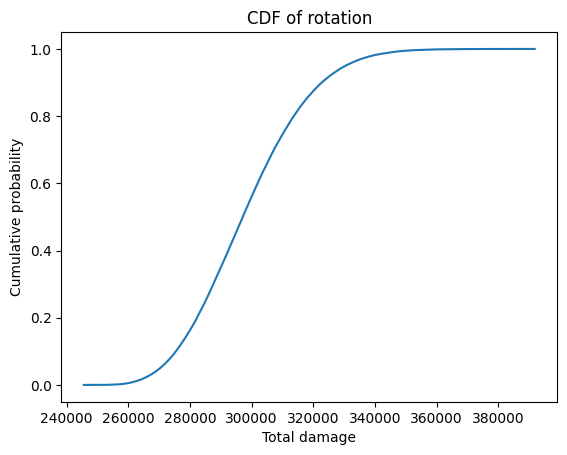

In [19]:
#@title PLD
test_name = 'PLD'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:   

  stats = Stats(wd=126, weapon_delay=2.24, main_stat=2891, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'PLD')
  rb= RotationBuilder(stats, skill_library)

  # #TODO: HolySpirit should delay autos, but this doesn't account for it. We also don't test it here.  
  rb.add_next_skill('HolySpirit')
  rb.add_next_skill('FastBlade')    
  rb.add_next_skill( 'Pot', 'General')  
  rb.add_next_skill('RiotBlade')
  rb.add_next_skill('RoyalAuthority')
  rb.add_next_skill('FightOrFlight')
  rb.add_next_skill('Requiescat')
  rb.add_next_skill('GoringBlade')
  rb.add_next_skill('CircleOfScorn')
  rb.add_next_skill('Explacion')
  rb.add_next_skill('Confiteor_Requiescat')
  rb.add_next_skill('Intervene')
  rb.add_next_skill('BladeOfFaith_Requiescat')
  rb.add_next_skill('Intervene')
  rb.add_next_skill('BladeOfTruth_Requiescat')
  rb.add_next_skill('BladeOfValor_Requiescat')
  rb.add_next_skill('HolySpirit_DivineMight')
  rb.add_next_skill('Atonement')
  rb.add_next_skill('Atonement')
  rb.add_next_skill('Atonement')

  sim = Simulator(stats, rb.build(enable_autos=True), verbose=False, num_samples=100000)  
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 9948, rb.get_last_event_time(), verbose=True)
  all_test_results.update_test_results(test_passed, test_name)

In [20]:
#@title SGE sim
test_name = 'SGE'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:   
  stats = Stats(wd=126, weapon_delay=2.8, main_stat=2946, det_stat=1900, crit_stat=2313, dh_stat=796, speed_stat=839, job_class = 'SGE')
  gcd_time = StatFns.get_time_using_speed_stat(stats.speed_stat, 2.5)

  rb= RotationBuilder(stats, skill_library, fight_start_time=-2.5)

  rb.add_next_skill('Pot', 'General')
  rb.add_next_skill('DosisIII')
  rb.add_next_skill('Eukrasia')
  rb.add_next_skill('EukrasianDosisIII')
  rb.add_next_skill('DosisIII')
  rb.add_next_skill('DosisIII')
  rb.add_next_skill('PhlegmaIII')
  rb.add_next_skill('PhlegmaIII')
  rb.add_next_skill('DosisIII')

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 9655, rb.get_last_event_time())
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: SGE===
Time taken: 0.3050689697265625
expected vs actual dps: 9655, 9652.343091563114
Test result: PASS


In [21]:
#@title SCH_bio_test sim
test_name = 'SCH_BIO_TEST'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'SCH', healer_or_caster_strength=351)

  rb= RotationBuilder(stats, skill_library)

  # rb.add_skill(0*gcd_time, 'Broil')
  # should return about 1146. just the broils
  # 3 bios: 1147, 2 bios: 1051, 1bio: 955
  rb.add_next_skill('Biolysis')
  rb.add_next_skill('Biolysis')
  rb.add_next_skill('Biolysis')
  rb.add_next_skill('ChainStrategem')
  fight_time = 13*StatFns.get_time_using_speed_stat(stats.speed_stat, 2.5)

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 1147, fight_time)
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: SCH_BIO_TEST===
Time taken: 0.2827308177947998
expected vs actual dps: 1147, 1147.3146856325493
Test result: PASS


In [22]:
#@title SCH sim
test_name = 'SCH'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'SCH', healer_or_caster_strength=351)  
  rb= RotationBuilder(stats, skill_library, fight_start_time=-2.5)

  rb.add_next_skill('Pot', 'General')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('Biolysis')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('ChainStrategem')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('EnergyDrain')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('BroilIV')
  rb.add_next_skill('BroilIV')
  rb.add_skill(0, 'Auto')

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 7455, rb.get_last_event_time())
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: SCH===
Time taken: 0.7164652347564697
expected vs actual dps: 7455, 7454.165939413061
Test result: PASS


In [23]:
#@title WAR all crit sim
test_name = 'WAR_crit'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'WAR')

  gcd_time= StatFns.get_time_using_speed_stat(stats.speed_stat, 2.5)
  rb= RotationBuilder(stats, skill_library)

  rb.add_skill(6.3, 'ChainStrategem', 'SCH')
  rb.add_skill(7.1, 'BattleLitany', 'DRG')
  rb.add_skill(0.8, 'ArcaneCircle', 'RPR')
  rb.add_skill(6.3, 'Embolden', 'RDM')
  
  rb.add_next_skill('HeavySwing', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('Maim', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('Pot', 'General')
  rb.add_next_skill('StormsEye', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('InnerChaos')
  rb.add_next_skill('Upheaval', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('Onslaught', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('PrimalRend', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('InnerChaos')
  rb.add_next_skill('Onslaught', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('Onslaught', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_next_skill('HeavySwing', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('Maim', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('StormsPath', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('FellCleave', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
  rb.add_next_skill('InnerChaos')
  
  #add auto-attacks
  cur_t = 0
  while cur_t <= 13*gcd_time:
    rb.add_skill(cur_t, 'Auto', guaranteed_crit=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS, guaranteed_dh=ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS)
    cur_t += stats.weapon_delay    

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 14170, rb.get_last_event_time())
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: WAR_crit===
Time taken: 0.9170455932617188
expected vs actual dps: 14170, 14170.773901230768
Test result: PASS


In [24]:
#@title SAM sim
test_name = 'SAM'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'SAM')  

  rb= RotationBuilder(stats, skill_library)
  rb.add_next_skill('Hakaze')
  rb.add_next_skill('Shifu')  

  sim = Simulator(stats, rb.build(), verbose=False, num_samples=100000)
  total_damage, dps_tracker, test_passed = do_test(test_name, sim, 6103, rb.get_last_event_time())
  all_test_results.update_test_results(test_passed, test_name)

===Doing test: SAM===
Time taken: 0.07654523849487305
expected vs actual dps: 6103, 6107.392108
Test result: PASS


In [25]:
#@title Pet skill status effect denylist test 1

test_name = 'Pet status effects1'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=2.96, main_stat=2910, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'TEST')
  
  fight_time = 100
  TOL = 0.03

  rb1= RotationBuilder(stats, skill_library)
  rb1.add_skill(0, 'Buff1')
  rb1.add_skill(1, 'Hit1')
  sim = Simulator(stats, rb1.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage1, _ = sim.simulate()  
  mean_total_damage1 = np.mean(total_damage1)

  rb2= RotationBuilder(stats, skill_library)
  rb2.add_skill(1, 'Buff1')
  rb2.add_skill(2, 'Pet_0')
  rb2.add_skill(3, 'Hit1')
  sim = Simulator(stats, rb2.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage2, _ = sim.simulate()  
  mean_total_damage2 = np.mean(total_damage2)

  total_damage_diff = np.abs(mean_total_damage1-mean_total_damage2)/mean_total_damage1
  test_passed =total_damage_diff < TOL
  test_result = "PASS" if test_passed else "FAIL"
  print("Test result: {result}".format(result=test_result))
  print("expected diff vs actual diff: {expected}, {actual}".format(expected=0, actual=total_damage_diff))
  all_test_results.update_test_results(test_passed, test_name)

Test result: PASS
expected diff vs actual diff: 0, 0.003453633017492003


In [26]:
#@title Pet skill status effect denylist test 2

test_name = 'Pet status effects2'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=2.96, main_stat=2910, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'TEST')
  
  fight_time = 100
  TOL = 0.03

  rb1= RotationBuilder(stats, skill_library)
  rb1.add_skill(0, 'Buff1')
  rb1.add_skill(2, 'Pet_350')
  sim = Simulator(stats, rb1.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage1, _ = sim.simulate()  
  mean_total_damage1 = np.mean(total_damage1)

  rb2= RotationBuilder(stats, skill_library)
  rb2.add_skill(2, 'Pet_350')
  
  sim = Simulator(stats, rb2.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage2, _ = sim.simulate()  
  mean_total_damage2 = np.mean(total_damage2)

  total_damage_diff = np.abs(mean_total_damage1-mean_total_damage2)/mean_total_damage1
  test_passed =total_damage_diff < TOL
  test_result = "PASS" if test_passed else "FAIL"
  print("Test result: {result}".format(result=test_result))
  print("expected diff vs actual diff: {expected}, {actual}".format(expected=0, actual=total_damage_diff))
  all_test_results.update_test_results(test_passed, test_name)

Test result: PASS
expected diff vs actual diff: 0, 0.001602159425234555


In [27]:
#@title Pet skill status effect denylist test 3

test_name = 'Pet status effects3'
if test_name in TEST_KEYS or 'all' in TEST_KEYS:
  stats = Stats(wd=126, weapon_delay=2.96, main_stat=2910, det_stat=1844, crit_stat=2377, dh_stat=1012, speed_stat=400, tenacity=751, job_class = 'TEST')
  
  fight_time = 100
  TOL = 0.5

  rb1= RotationBuilder(stats, skill_library)
  rb1.add_skill(0, 'Buff2')
  rb1.add_skill(2, 'Pet_350')
  sim = Simulator(stats, rb1.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage1, _ = sim.simulate()  
  mean_total_damage1 = np.mean(total_damage1)

  rb2= RotationBuilder(stats, skill_library)
  rb2.add_skill(2, 'Pet_350')
  
  sim = Simulator(stats, rb2.build(end_time=fight_time, enable_autos=False), verbose=False, num_samples=20000)
  total_damage2, _ = sim.simulate()  
  mean_total_damage2 = np.mean(total_damage2)

  total_damage_diff = np.abs(mean_total_damage1-mean_total_damage2)/mean_total_damage1
  # Not a bug- Buff2 is not denylisted so it really should have an effect
  test_passed = total_damage_diff > TOL
  test_result = "PASS" if test_passed else "FAIL"
  print("Test result: {result}".format(result=test_result))
  print("expected diff vs actual diff: {expected}, {actual}".format(expected=0, actual=total_damage_diff))
  all_test_results.update_test_results(test_passed, test_name)

Test result: PASS
expected diff vs actual diff: 0, 0.6672730697240661


In [28]:
all_test_results.print_result()

13/13 tests passed.


In [29]:
#@title normality test stuff. feel free to ignore

# import scipy.stats
# import statsmodels.api as sm

# mean = np.mean(total_damage)
# std = np.std(total_damage)
# gauss_samp = np.random.randn(1000000,)*std+mean

# print(scipy.stats.normaltest(total_damage))
# print(scipy.stats.normaltest(gauss_samp))

# def get_pdf(vals):  
#   count, bins_count = np.histogram(vals, bins=np.arange(np.min(total_damage),np.max(total_damage),(np.max(total_damage)-np.min(total_damage))/1000))
#   pdf = count / sum(count)
#   return bins_count, pdf

# bins_count, pdf = get_pdf(total_damage)
# bins_count_gauss, pdf_gauss = get_pdf(gauss_samp)

# plt.figure()
# plt.plot(bins_count[1:], pdf, label="PDF")
# plt.plot(bins_count_gauss[1:], pdf_gauss, label="PDF", color='g')
# plt.show()

# # sanity check
# print('total damage mean/std: {mean}/{std}'.format(mean=np.mean(total_damage), std=np.std(total_damage)))
# print('total damage mean/std: {mean}/{std}'.format(mean=np.mean(gauss_samp), std=np.std(gauss_samp)))

# plt.figure()
# sm.qqplot((total_damage-np.mean(total_damage))/np.std(total_damage), line='45')